In [1]:
import os
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import torch

from torch import nn
from torch.utils.data import DataLoader

import time

In [2]:
class ChordTypeDataset(Dataset):

    def __init__(self, annotations_file, audio_dir, transformation, target_sample_rate, num_samples, device):
        self.audio_dir = audio_dir
        self.device = device
        self.annotations = pd.read_csv(annotations_file)
        self.transformation = transformation.to(self.device)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)
        
    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sample_rate = torchaudio.load(audio_sample_path)
        # Signal -> PyTorch Tensor (num_channels, samples)

        # Send signal to device (CUDA or CPU)
        signal = signal.to(self.device)
        
        # Make the audio signals have a uniform audio rate
        signal = self._resample(signal, sample_rate)
        # Make the audio mono
        signal = self._mixdown(signal)

        # Cut the audio to fit the necessary length
        signal = self._cut(signal)
        # Right pad the audio to fit the necessary length
        signal = self._right_pad(signal)

        
        signal = self.transformation(signal)
        return signal, label

    def _cut(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:,:self.num_samples]
        return signal

    def _right_pad(self, signal):
        signal_length = signal.shape[1]
        if signal_length < self.num_samples:
            num_missing_samples = self.num_samples - signal_length
            end_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, end_padding)
        return signal

    def _resample(self, signal, original_sample_rate):
        # If the current sample rate is not the same as the target sample rate
        if original_sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(original_sample_rate, self.target_sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def _mixdown(self, signal):
        # If the audio is not already mono, make it mono
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdims=True)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index,1])
        return path

    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index,2]

In [3]:
class MyCNNNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 4 convolutional blocks / flatten / linear / softmax

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(128 * 5 * 9, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # #print(x.shape)
        # x = self.conv1(x)
        # #print(x.shape)
        # x = self.conv2(x)
        # #print(x.shape)
        # x = self.conv3(x)
        # #print(x.shape)
        # x = self.conv4(x)
        # #print(x.shape)
        # x = self.flatten(x)
        # #print(x.shape)
        # x = self.linear(x)
        # #print(x.shape)
        # predictions = self.softmax(x)
        # #print(predictions.shape)
        return self.softmax(self.linear(self.flatten(self.conv4(self.conv3(self.conv2(self.conv1(x)))))))

In [4]:
def train_step(model, data_loader, loss_function, optimiser, device):
    # Put the model in train mode
    model.train()

    train_loss, train_accuracy = 0, 0

    for batch, (X,y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        y_predicted = model(X)
        loss = loss_function(y_predicted, y)
        train_loss += loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        y_predicted_class = torch.argmax(y_predicted, dim=1)
        train_accuracy += (y_predicted_class==y).sum().item()/len(y_predicted)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(data_loader)
    train_accuracy = train_accuracy / len(data_loader)
    return train_loss, train_accuracy

In [5]:
def test_step(model, data_loader, loss_function, optimiser, device):
    # Put the model in eval mode
    model.eval()

    test_loss, test_accuracy = 0, 0

    # Turn on inference mode:
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
    
            y_predicted = model(X)
            loss = loss_function(y_predicted, y)
            test_loss += loss.item()
    
            y_predicted_class = torch.argmax(y_predicted, dim=1)
            test_accuracy += (y_predicted_class==y).sum().item()/len(y_predicted)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(data_loader)
    test_accuracy = test_accuracy / len(data_loader)
    return test_loss, test_accuracy

In [6]:
def train(model, train_data_loader, test_data_loader, loss_function, optimiser, device, epochs):
    results = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": [], "epoch_time": []}

    for epoch in range(epochs):
        torch.cuda.current_stream().synchronize()
        start = time.perf_counter()
        
        train_loss, train_accuracy = train_step(model, train_data_loader, loss_function, optimiser, device)
        test_loss, test_accuracy = test_step(model, test_data_loader, loss_function, optimiser, device)
        
        torch.cuda.current_stream().synchronize()
        end = time.perf_counter()

        epoch_time = (end - start)
        
        
        print(f"Epoch {epoch+1} | Train Loss {train_loss:.4f} | Train Accuracy {train_accuracy:.4f} | Test Loss {test_loss:.4f} | Test Accuracy {test_accuracy:.4f} | Elapsed Time {epoch_time:.4f}s")

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)
        results["epoch_time"].append(epoch_time)

    return results
        

# Train Model From Scratch

In [7]:
ANNOTATIONS_FILE = 'C:/Users/indys/Desktop/Computer Science Software/Fall2024/Parallel/FinalProject/chord_type.csv'
AUDIO_DIR = 'C:/Users/indys/Desktop/Computer Science Software/Fall2024/Parallel/FinalProject/chordDataset'
RAND_SEED = 13
# Should be less than or equal to 86400
NUM_DATA_ITEMS = 86400

torch.manual_seed(RAND_SEED)
torch.cuda.manual_seed(RAND_SEED)

# Sample Rate should be 16000 Hz
SAMPLE_RATE = 16000
# Each item should be 4 seconds long
NUM_SAMPLES = 4*SAMPLE_RATE

# Additional Parameters
EPOCHS = 30
LEARNING_RATE = 1e-5
BATCH_SIZE = 32

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
#device = "cpu"

print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=64).to(device)

# Number of data items should be <= 86400
ctd, unused = torch.utils.data.random_split(ChordTypeDataset(ANNOTATIONS_FILE, AUDIO_DIR, mel_spectrogram, SAMPLE_RATE, NUM_SAMPLES, device), [NUM_DATA_ITEMS, 86400 - NUM_DATA_ITEMS])

training_data, testing_data = torch.utils.data.random_split(ctd, [0.7, 0.3])
print(f"There are {len(training_data)} items in the training dataset")
print(f"There are {len(testing_data)} items in the testing dataset")


# Create a data loader for the training set
train_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False)

# Create Network
chord_classifier = MyCNNNetwork(4).to(device)

# Instantiate Loss Function and Optimizer
loss_function = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(chord_classifier.parameters(), lr=LEARNING_RATE)

torch.cuda.synchronize()
start = time.perf_counter()
results = train(chord_classifier, train_data_loader, test_data_loader, loss_function, optimiser, device, EPOCHS)
torch.cuda.synchronize()
end = time.perf_counter()

epoch_time = (end - start)

print(f"Total Elapsed Time {epoch_time:.4f}s")

torch.save(chord_classifier.state_dict(), "ChordTypeCNN.pth")

print("Model trained and stored as ChordTypeCNN.pth")


Using device cuda
There are 60480 items in the training dataset
There are 25920 items in the testing dataset
Epoch 1 | Train Loss 1.3126 | Train Accuracy 0.4325 | Test Loss 1.2307 | Test Accuracy 0.5496 | Elapsed Time 278.4007s
Epoch 2 | Train Loss 1.1691 | Train Accuracy 0.6383 | Test Loss 1.1289 | Test Accuracy 0.6808 | Elapsed Time 278.8727s
Epoch 3 | Train Loss 1.1062 | Train Accuracy 0.6985 | Test Loss 1.0852 | Test Accuracy 0.7216 | Elapsed Time 293.2831s
Epoch 4 | Train Loss 1.0606 | Train Accuracy 0.7458 | Test Loss 1.0387 | Test Accuracy 0.7818 | Elapsed Time 289.4094s
Epoch 5 | Train Loss 1.0317 | Train Accuracy 0.7817 | Test Loss 1.0135 | Test Accuracy 0.8039 | Elapsed Time 300.5364s
Epoch 6 | Train Loss 1.0100 | Train Accuracy 0.8036 | Test Loss 1.0012 | Test Accuracy 0.8184 | Elapsed Time 281.3073s
Epoch 7 | Train Loss 0.9932 | Train Accuracy 0.8225 | Test Loss 0.9930 | Test Accuracy 0.8271 | Elapsed Time 277.5966s
Epoch 8 | Train Loss 0.9798 | Train Accuracy 0.8332 | Test

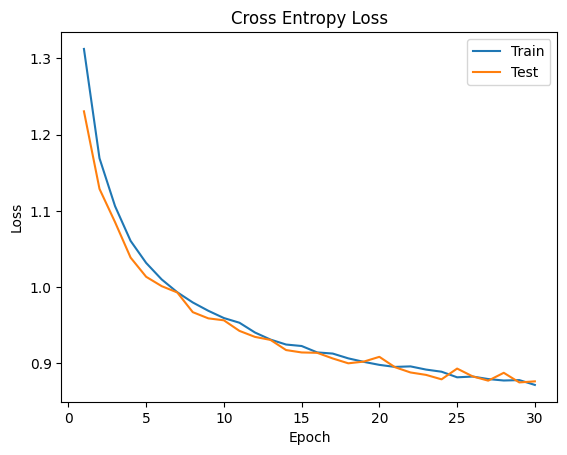

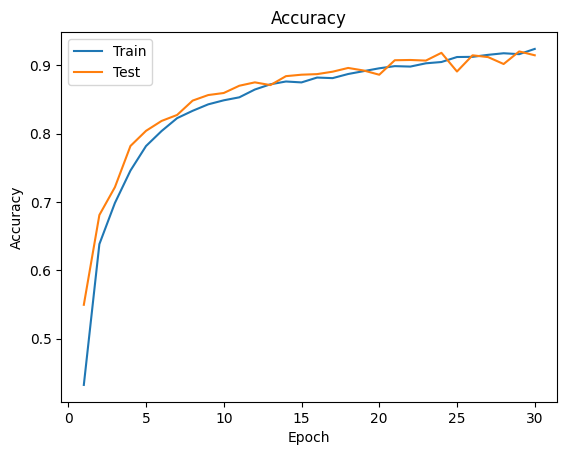

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1,EPOCHS+1),results['train_loss'])
plt.plot(range(1,EPOCHS+1),results['test_loss'])
plt.title('Cross Entropy Loss')
plt.legend(['Train','Test'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(range(1,EPOCHS+1),results['train_accuracy'])
plt.plot(range(1,EPOCHS+1),results['test_accuracy'])
plt.title('Accuracy')
plt.legend(['Train','Test'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Train Existing Model